# Matrix Factorisation - Implicit

Implicit Matrix Factorization 

- Where ratings of less than threshold are implied as preferences
- Also uses negative sampling to improve performance

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split, neg_feedback_samples
from reco.evaluate import user_item_crossjoin, filter_by

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [12]:
df_implicit = neg_feedback_samples(df_ratings, rating_threshold=3, ratio_neg_per_user=1)
df_implicit["unix_timestamp"] = 1

In [13]:
df_implicit.head()

,user_id,movie_id,rating,unix_timestamp
0,1,61,1,1
298,1,866,0,1
297,1,510,0,1
296,1,102,0,1
295,1,886,0,1


In [14]:
df_ratings.shape, df_implicit.shape

((100000, 4), (165040, 4))

In [15]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_implicit, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [16]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [17]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(0, 1)

In [18]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = random_split(DATA, [0.8, 0.2])

In [19]:
train.shape, test.shape

((132032, 7), (33008, 7))

## Implicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [20]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

Using TensorFlow backend.


### Build the Model

In [21]:
def ImplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [22]:
n_factors = 40
model = ImplicitMF(n_users, n_items, n_factors)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
____________________________________________________________________________________________

In [24]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists /tf/recommendation/MovieLens/model-img


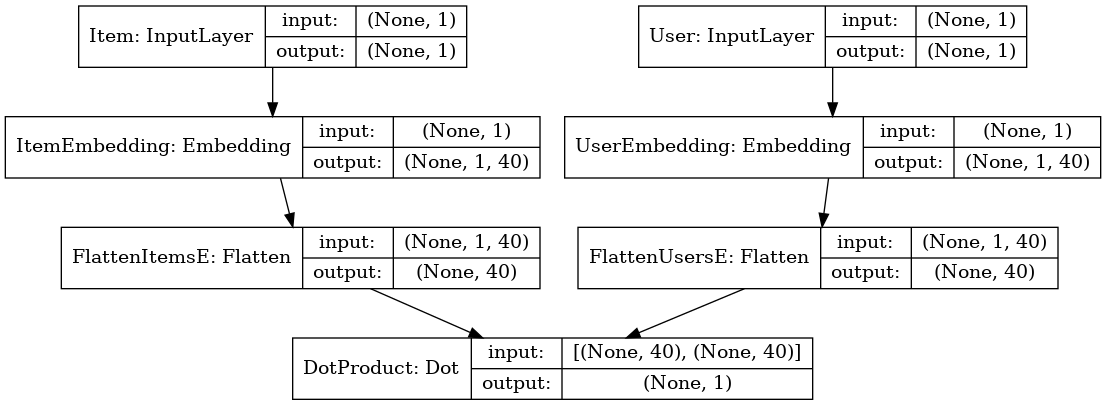

In [25]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/implicit-mf.png" )

### Train the Model

In [26]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Train on 105625 samples, validate on 26407 samples
Epoch 1/5
105625/105625 [==============================] - 1s 13us/step - loss: 5.1243 - val_loss: 5.4790
Epoch 2/5
105625/105625 [==============================] - 1s 11us/step - loss: 3.8033 - val_loss: 5.5095
Epoch 3/5
105625/105625 [==============================] - 1s 11us/step - loss: 2.7633 - val_loss: 5.5116
Epoch 4/5
105625/105625 [==============================] - 1s 11us/step - loss: 2.2474 - val_loss: 5.5001
Epoch 5/5
105625/105625 [==============================] - 1s 11us/step - loss: 1.9536 - val_loss: 5.4998
CPU times: user 11 s, sys: 825 ms, total: 11.8 s
Wall time: 6.24 s


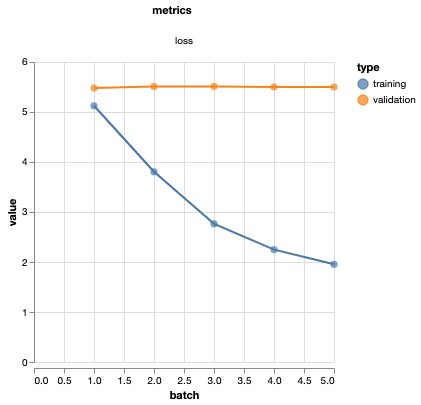

In [27]:
vis.metrics(output.history)

### Score the Model

In [28]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

33008/33008 [==============================] - 0s 12us/step


5.270339922588526

### Evaluate the Model

In [29]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [30]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [31]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 15.6 s, sys: 1.51 s, total: 17.1 s
Wall time: 11.8 s


In [32]:
predictions.head()

,USER,ITEM,RATING_PRED
0,0,60,0.104562
1,0,865,0.117103
2,0,509,0.197329
3,0,101,0.092993
4,0,885,0.062903


In [33]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 18.4 s, sys: 1.75 s, total: 20.1 s
Wall time: 14.8 s


In [34]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.114297
Precision@K:	0.082323
Recall@K:	0.005124


### Get Similar Items

In [35]:
from reco.recommend import get_similar, show_similar

In [36]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 128 ms


In [37]:
item_similar_indices

array([[   0,  226,   49,  120,   47],
       [   1,   80, 1047,  144,  810],
       [   2, 1106,   46,  215,  284],
       ...,
       [1679, 1430, 1649, 1515,  912],
       [1680, 1646, 1396, 1425,  438],
       [1681, 1293,   77, 1095, 1303]])

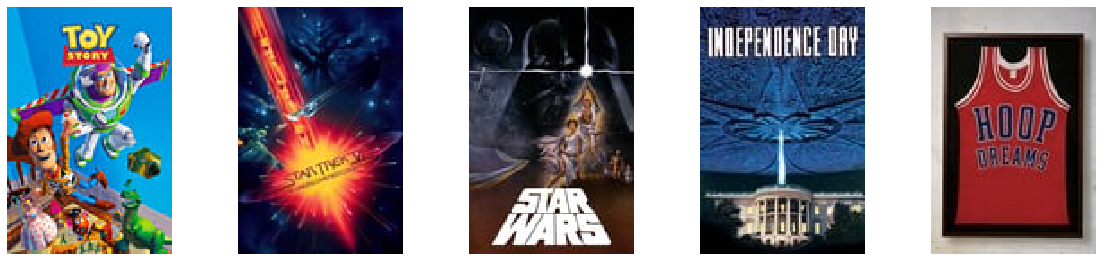

In [38]:
show_similar(0, item_similar_indices, item_encoder)